# Start Django 

In [ ]:
# ipykarnel seçilecek (kayıtlı olması da gerekli)
import django
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = 'true'
import sys
os.chdir(os.path.abspath(".."))
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../"))
# if not django.apps.apps.ready:
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "config.settings.develop")
os.environ['DJANGO_SETTINGS_MODULE'] = 'config.settings.develop'
django.setup()

# Sayaçların her bir tickinin liner gösterimi

In [27]:
from collections import defaultdict, OrderedDict
from django.db.models.functions import TruncWeek, TruncMonth
from counter.models import CounterEntry
from django.contrib.auth import get_user_model

User = get_user_model()

def get_weekly_grouped_entries():
    user = User.objects.first()

    # Entry bazlı çalışıyoruz
    entries = CounterEntry.objects.filter(counter__user=user).annotate(
        week=TruncWeek('timestamp'),
        month=TruncMonth('timestamp')
    ).select_related('counter').order_by('month', 'week', 'timestamp')

    grouped = defaultdict(lambda: defaultdict(list))

    for entry in entries:
        month_key = entry.month.strftime('%Y-%m')
        week_key = entry.week.strftime('%Y-%m-%d')
        grouped[month_key][week_key].append({
            'counter_id': entry.counter.id,
            'counter_name': entry.counter.name,
            'entry_id': entry.id,
            'value': entry.value,
            'timestamp': entry.timestamp.isoformat()
        })

    # Sıralı sonuç
    result = OrderedDict()
    for month in sorted(grouped.keys()):
        result[month] = [
            {
                'week': week,
                'counters': grouped[month][week]
            }
            for week in sorted(grouped[month].keys())
        ]

    return result


In [28]:
data = get_weekly_grouped_entries()

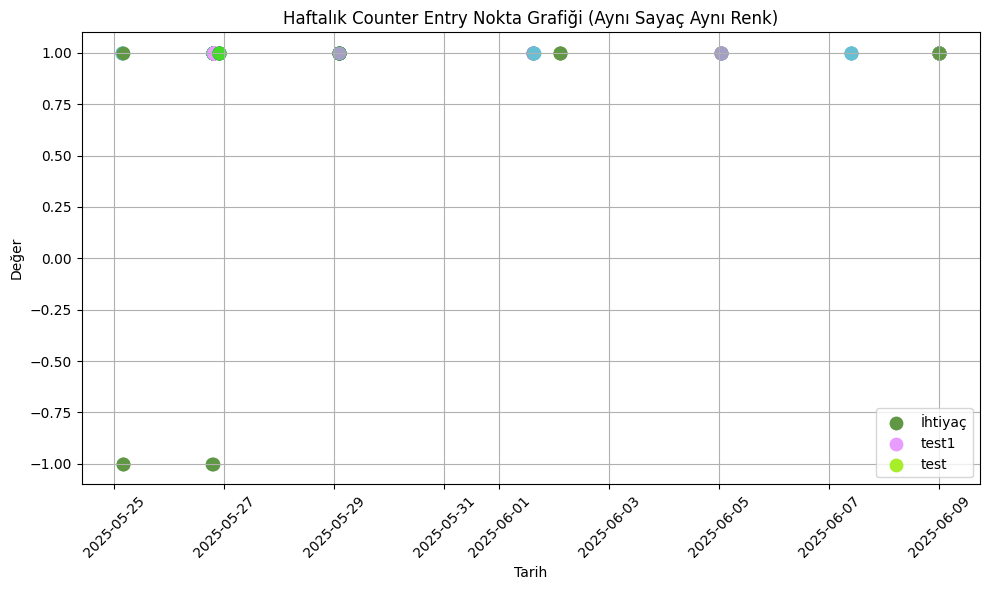

In [29]:
# Aynı counter için aynı renk - tekrar çizim
plt.figure(figsize=(10, 6))
counter_colors = {}

for month, weeks in data.items():
    for week_data in weeks:
        for entry in week_data['counters']:
            counter_id = entry['counter_id']
            counter_name = entry['counter_name']
            if counter_id not in counter_colors:
                # Aynı counter_id için sabit random renk
                counter_colors[counter_id] = [random.random() for _ in range(3)]

            timestamp = datetime.fromisoformat(entry['timestamp'].replace('Z', '+00:00'))
            plt.scatter(timestamp, entry['value'], label=counter_name,
                        color=counter_colors[counter_id], s=80)

# Etiketleri tekrar etmeden göster
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Haftalık Counter Entry Nokta Grafiği (Aynı Sayaç Aynı Renk)")
plt.xlabel("Tarih")
plt.ylabel("Değer")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Sayaçların günlük toplamlarının liner gösterimi

In [23]:
from collections import defaultdict, OrderedDict
from django.db.models.functions import TruncWeek, TruncMonth
from counter.models import CounterEntry
from django.contrib.auth import get_user_model

User = get_user_model()


def get_weekly_grouped_totals():

    user = User.objects.first()

    # entries üzerinden join yaparak haftalık + aylık değerler çekiyoruz
    data = Counter.objects.filter(user=user, entries__isnull=False) \
        .annotate(
            week=TruncWeek('entries__timestamp'),
            month=TruncMonth('entries__timestamp')
        ).values(
            'month', 'week', 'id', 'name'
        ).annotate(
            total=Sum('entries__value')
        ).order_by('month', 'week')

    # Geçici gruplama yapılacak yer
    grouped = defaultdict(lambda: defaultdict(list))

    for item in data:
        month_key = item['month'].strftime('%Y-%m')
        week_key = item['week'].strftime('%Y-%m-%d')
        grouped[month_key][week_key].append({
            'counter_id': item['id'],
            'name': item['name'],
            'total': item['total']
        })

    # Sıralı sonuç
    result = OrderedDict()
    for month in sorted(grouped.keys()):
        result[month] = [
            {
                'week': week,
                'counters': grouped[month][week]
            }
            for week in sorted(grouped[month].keys())
        ]
    
    return result

In [ ]:
get_weekly_grouped_totals()

In [24]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime
import random
from collections import defaultdict, OrderedDict

In [25]:
data = get_weekly_grouped_totals()

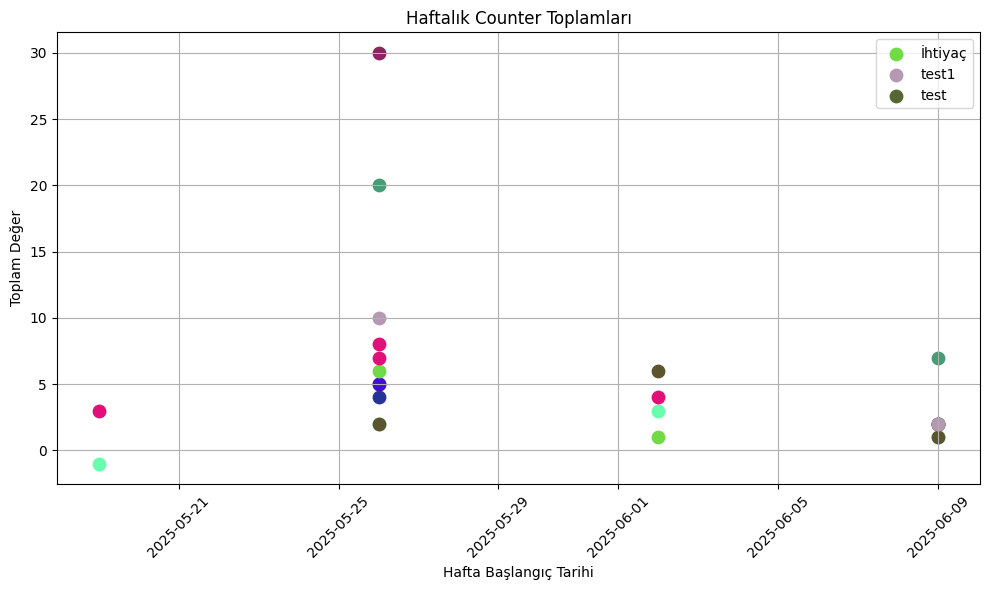

In [26]:

# Plot fonksiyonu
def plot_weekly_grouped_totals(data):
    plt.figure(figsize=(10, 6))
    counter_colors = {}

    for month, weeks in data.items():
        for week_data in weeks:
            for entry in week_data['counters']:
                counter_id = entry['counter_id']
                counter_name = entry['name']
                if counter_id not in counter_colors:
                    # Aynı counter_id için sabit random renk
                    counter_colors[counter_id] = [random.random() for _ in range(3)]

                # Haftayı tarih nesnesine dönüştür
                week_start = datetime.strptime(week_data['week'], '%Y-%m-%d')
                plt.scatter(week_start, entry['total'], label=counter_name,
                            color=counter_colors[counter_id], s=80)

    # Etiketleri tekrar etmeden göster
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Haftalık Counter Toplamları")
    plt.xlabel("Hafta Başlangıç Tarihi")
    plt.ylabel("Toplam Değer")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Veriyi çiz
plot_weekly_grouped_totals(data)